# **Importing Modules**

In [1]:
import numpy as np      # To use np.arrays
import pandas as pd     # To use dataframes
from pandas.plotting import autocorrelation_plot as auto_corr

# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

#For date-time
import math
from datetime import datetime
from datetime import timedelta

# Another imports if needs
import itertools
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose as season
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.linear_model import LinearRegression 
from sklearn import preprocessing

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
 

 


# **Importing Datasets**

In [2]:
df_train = pd.read_csv('Resources/train.csv')
df_stores = pd.read_csv('Resources/stores.csv')
df_features = pd.read_csv('Resources/features.csv')

In [3]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
df_stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [5]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


# **Data Prep**

In [6]:
df = df_train.merge(df_features,how='left',indicator=True).merge(df_stores,how='left')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,_merge,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,both,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,both,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,both,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,both,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,both,A,151315


In [7]:
df.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
_merge               0
Type                 0
Size                 0
dtype: int64

In [8]:
# MARK downs has a lot of null for this model we will drop this column and might come back to see if this does change anything as well as '_merge'
df =df.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','_merge'],axis=1)
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,211.350143,8.106,A,151315


In [9]:
# Check weekly sales for outliners with negative values 
df.loc[df['Weekly_Sales']<=0] #outliers

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
846,1,6,2012-08-10,-139.65,False,85.05,3.494,221.958433,6.908,A,151315
2384,1,18,2012-05-04,-1.27,False,75.55,3.749,221.671800,7.143,A,151315
6048,1,47,2010-02-19,-863.00,False,39.93,2.514,211.289143,8.106,A,151315
6049,1,47,2010-03-12,-698.00,False,57.79,2.667,211.380643,8.106,A,151315
6051,1,47,2010-10-08,-58.00,False,63.93,2.633,211.746754,7.838,A,151315
...,...,...,...,...,...,...,...,...,...,...,...
419597,45,80,2010-02-12,-0.43,True,27.73,2.773,181.982317,8.992,B,118221
419598,45,80,2010-02-19,-0.27,False,31.27,2.745,182.034782,8.992,B,118221
419603,45,80,2010-04-16,-1.61,False,54.28,2.899,181.692477,8.899,B,118221
419614,45,80,2010-07-02,-0.27,False,76.61,2.815,182.318780,8.743,B,118221


In [10]:
df  =df.loc[df['Weekly_Sales']>0]
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,211.350143,8.106,A,151315


In [11]:
df['year'] = pd.DatetimeIndex(df['Date']).year #Separating year data.
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315,2010
1,1,1,2010-02-12,46039.49,True,38.51,2.548,211.242170,8.106,A,151315,2010
2,1,1,2010-02-19,41595.55,False,39.93,2.514,211.289143,8.106,A,151315,2010
3,1,1,2010-02-26,19403.54,False,46.63,2.561,211.319643,8.106,A,151315,2010
4,1,1,2010-03-05,21827.90,False,46.50,2.625,211.350143,8.106,A,151315,2010


In [12]:
df['month'] = pd.DatetimeIndex(df['Date']).month #extract month data
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,year,month
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315,2010,2
1,1,1,2010-02-12,46039.49,True,38.51,2.548,211.242170,8.106,A,151315,2010,2
2,1,1,2010-02-19,41595.55,False,39.93,2.514,211.289143,8.106,A,151315,2010,2
3,1,1,2010-02-26,19403.54,False,46.63,2.561,211.319643,8.106,A,151315,2010,2
4,1,1,2010-03-05,21827.90,False,46.50,2.625,211.350143,8.106,A,151315,2010,3


In [13]:
df.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
Type             object
Size              int64
year              int32
month             int32
dtype: object

In [14]:
df['Date'] =   pd.to_datetime(df['Date'])

In [15]:
df.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
Type                    object
Size                     int64
year                     int32
month                    int32
dtype: object

In [16]:
df['week'] =  df['Date'].dt.isocalendar().week
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,year,month,week
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315,2010,2,5
1,1,1,2010-02-12,46039.49,True,38.51,2.548,211.242170,8.106,A,151315,2010,2,6
2,1,1,2010-02-19,41595.55,False,39.93,2.514,211.289143,8.106,A,151315,2010,2,7
3,1,1,2010-02-26,19403.54,False,46.63,2.561,211.319643,8.106,A,151315,2010,2,8
4,1,1,2010-03-05,21827.90,False,46.50,2.625,211.350143,8.106,A,151315,2010,3,9


C:\Users\david\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\david\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\david\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

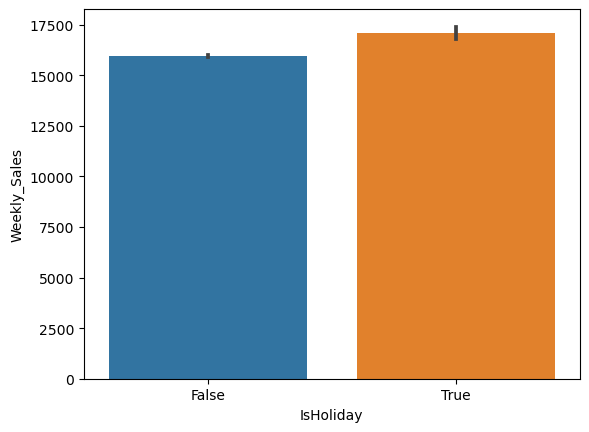

In [17]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df)

In [18]:
df_holiday = df.loc[df['IsHoliday']==True]
df_holiday['Date'].nunique() 

10

In [19]:
df_not_holiday = df.loc[df['IsHoliday']==False]
df_not_holiday['Date'].nunique() 

133

In [20]:
# Super bowl dates in train set
df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True
df.loc[(df['Date'] != '2010-02-12')&(df['Date'] != '2011-02-11')&(df['Date'] != '2012-02-10'),'Super_Bowl'] = False

C:\Users\david\AppData\Local\Temp\ipykernel_45212\38026190.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[(df['Date'] == '2010-02-12')|(df['Date'] == '2011-02-11')|(df['Date'] == '2012-02-10'),'Super_Bowl'] = True


In [21]:
# Labor day dates in train set
df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True
df.loc[(df['Date'] != '2010-09-10')&(df['Date'] != '2011-09-09')&(df['Date'] != '2012-09-07'),'Labor_Day'] = False


C:\Users\david\AppData\Local\Temp\ipykernel_45212\1442081191.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[(df['Date'] == '2010-09-10')|(df['Date'] == '2011-09-09')|(df['Date'] == '2012-09-07'),'Labor_Day'] = True


In [22]:
# Thanksgiving dates in train set
df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True
df.loc[(df['Date'] != '2010-11-26')&(df['Date'] != '2011-11-25'),'Thanksgiving'] = False

C:\Users\david\AppData\Local\Temp\ipykernel_45212\2744260695.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[(df['Date'] == '2010-11-26')|(df['Date'] == '2011-11-25'),'Thanksgiving'] = True


In [23]:
#Christmas dates in train set
df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True
df.loc[(df['Date'] != '2010-12-31')&(df['Date'] != '2011-12-30'),'Christmas'] = False

C:\Users\david\AppData\Local\Temp\ipykernel_45212\3756870649.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[(df['Date'] == '2010-12-31')|(df['Date'] == '2011-12-30'),'Christmas'] = True


C:\Users\david\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\david\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\david\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Christmas', ylabel='Weekly_Sales'>

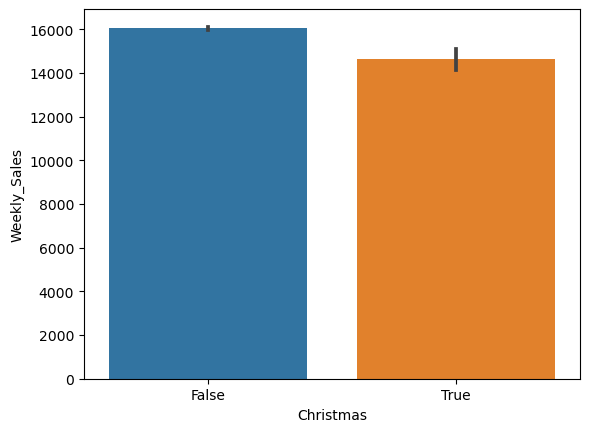

In [24]:
sns.barplot(x='Christmas', y='Weekly_Sales', data=df) # Christmas holiday vs not-Christmas

C:\Users\david\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\david\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\david\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Thanksgiving', ylabel='Weekly_Sales'>

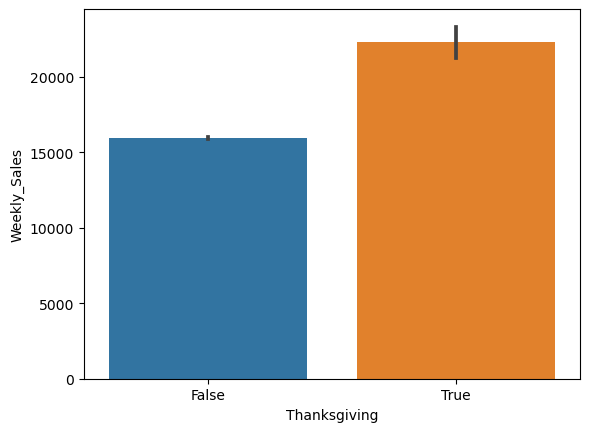

In [25]:
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=df) # Thanksgiving holiday vs not-thanksgiving

C:\Users\david\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\david\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\david\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Super_Bowl', ylabel='Weekly_Sales'>

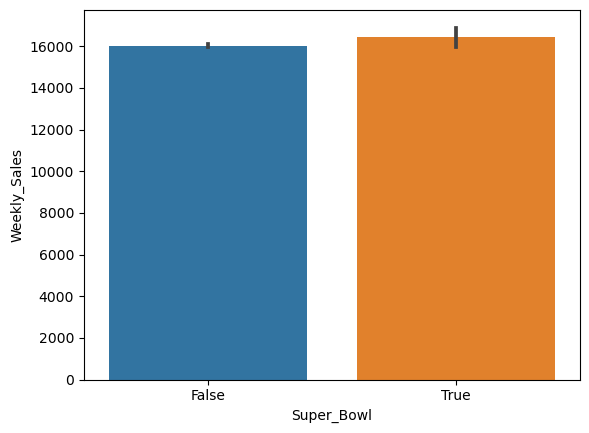

In [26]:
sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=df) # Super bowl holiday vs not-super bowl

C:\Users\david\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\david\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\david\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Labor_Day', ylabel='Weekly_Sales'>

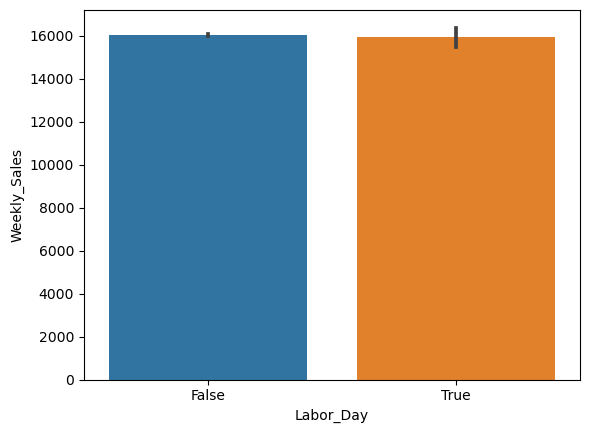

In [27]:
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=df) # Labor day holiday vs not-labor day

In [28]:
 
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()



# Encode labels in column 'species'.
DataTrain_outliners['IsHoliday']= label_encoder.fit_transform(DataTrain_outliners['IsHoliday'])
DataTrain_outliners['Type']= label_encoder.fit_transform(DataTrain_outliners['Type'])

DataTrain_outliners.head()

NameError: name 'DataTrain_outliners' is not defined

In [ ]:
data = DataTrain_outliners

# prints data that will be plotted
# columns shown here are selected by corr() since
# they are ideal for the plot
print(data.corr())
sns.set_theme(style="whitegrid")
# plotting correlation heatmap
dataplot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)
sns.set(rc = {'figure.figsize':(25,8)})

# displaying heatmap
mp.show()

In [ ]:
DataTrain_test =DataTrain_outliners.drop(['Store','Dept','Date'],axis=1)

In [ ]:
data1 = DataTrain_test

# prints data that will be plotted
# columns shown here are selected by corr() since
# they are ideal for the plot
print(data1.corr())
sns.set_theme(style="whitegrid")
# plotting correlation heatmap
dataplot = sns.heatmap(data1.corr(), cmap="YlGnBu", annot=True)
sns.set(rc = {'figure.figsize':(25,8)})

# displaying heatmap
mp.show()